In [9]:
import os, glob, inspect
import copy
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 200)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import rankdata
from scipy import stats
from datetime import datetime, timedelta
import string

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import mixture
from math import pi
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from kneed import DataGenerator, KneeLocator
from sklearn.feature_selection import f_regression
import pprint
import sklearn
from sklearn import tree
from sklearn.tree import export_text
from sklearn.tree import _tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, _tree
import uuid
from importlib.machinery import SourceFileLoader

cwd = os.getcwd()
today = datetime.today().strftime('%Y-%m-%d')
colors = ['r','g','b','c','m','y','k']

print(cwd)
print(today)

/home/cst/SmartTradzt/Github/Price-Segmentation
2021-07-29


# Functions and Constanta

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def export_py_code(tree, feature_names, max_depth=3, spacing=4):
    if spacing < 2:
        raise ValueError('spacing must be > 1')

    # Clean up feature names (for correctness)
    nums = string.digits
    alnums = string.ascii_letters + nums
    clean = lambda s: ''.join(c if c in alnums else '_' for c in s)
    features = [clean(x) for x in feature_names]
    features = ['_'+x if x[0] in nums else x for x in features if x]
    if len(set(features)) != len(feature_names):
        raise ValueError('invalid feature names')

    # First: export tree to text
    res = export_text(tree, feature_names=features, 
                        max_depth=max_depth,
                        decimals=6,
                        spacing=spacing-1)

    # Second: generate Python code from the text
    skip, dash = ' '*spacing, '-'*(spacing-1)
    code = 'def decision_tree({}):\n'.format(', '.join(features))
    for line in repr(tree).split('\n'):
        code += skip + "# " + line + '\n'
    for line in res.split('\n'):
        line = line.rstrip().replace('|',' ')
        if '<' in line or '>' in line:
            line, val = line.rsplit(maxsplit=1)
            line = line.replace(' ' + dash, 'if')
            line = '{} {:g}:'.format(line, float(val))
        else:
            line = line.replace(' {} class:'.format(dash), 'return')
        code += skip + line + '\n'

    return code.replace('- value:','return').replace('-','')

def get_func_args(f):
    if hasattr(f, 'args'):
        return f.args
    else:
        return list(inspect.signature(f).parameters)

def tree_to_df(reg_tree, feature_names):
    tree_ = reg_tree.tree_
    feature_name = [
        feature_names[i] if i != sklearn.tree._tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, row, ret):
        if tree_.feature[node] != sklearn.tree._tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Add rule to row and search left branch
            row[-1].append(name + " <= " +  str(threshold))
            recurse(tree_.children_left[node], row, ret)
            # Add rule to row and search right branch
            row[-1].append(name + " > " +  str(threshold))
            recurse(tree_.children_right[node], row, ret)
        else:
            # Add output rules and start a new row
            label = tree_.value[node]
            ret.append("return " + str(label[0][0]))
            row.append([])
    
    # Initialize
    rules = [[]]
    vals = []
    
    # Call recursive function with initial values
    recurse(0, rules, vals)
    
    # Convert to table and output
    df = pd.DataFrame(rules).dropna(how='all')
    df['Return'] = pd.Series(vals)
    return df


def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

def tree_to_df(reg_tree, feature_names):
    tree_ = reg_tree.tree_
    feature_name = [
        feature_names[i] if i != sklearn.tree._tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, row, ret):
        if tree_.feature[node] != sklearn.tree._tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Add rule to row and search left branch
            row[-1].append(name + " <= " +  str(threshold))
            recurse(tree_.children_left[node], row, ret)
            # Add rule to row and search right branch
            row[-1].append(name + " > " +  str(threshold))
            recurse(tree_.children_right[node], row, ret)
        else:
            # Add output rules and start a new row
            label = tree_.value[node]
            ret.append("return " + str(label[0][0]))
            row.append([])
    
    # Initialize
    rules = [[]]
    vals = []
    
    # Call recursive function with initial values
    recurse(0, rules, vals)
    
    # Convert to table and output
    df = pd.DataFrame(rules).dropna(how='all')
    df['Return'] = pd.Series(vals)
    return df

In [11]:
# Set minimum accepted cluster

# min_cluster = 3
# min_component = 2 # for PCA
categorical_features = []
numerical_features = []
target = 'Price Premium'

# tree setting
max_depth=3
# min_samples_split=200
min_samples_leaf=100
ccp_alpha=0.001

In [12]:
filename = 'Polymer Spot Sales Contract v2.xlsx'
filepath = os.path.join(cwd,'InternalData',filename)
print(filepath)

/home/cst/SmartTradzt/Github/Price-Segmentation/InternalData/Polymer Spot Sales Contract v2.xlsx


In [13]:
data = pd.read_excel(filepath,sheet_name='Polymer Spot Sales Contract')

In [14]:
data.shape

(1817, 33)

In [15]:
# data['Price Premium Pctg'] = data['Price Premium']/data['REFERENCE_MARKET_PRICE']

In [16]:
data.head()

,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Sold to Customer Code,Customer Type,Customer Industry,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE
0,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,8010000770,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.000000,1177.000000
1,2017-11-22,QTN-0000013779-1,1,30012429,QUOTATION,CJ POLYMERS SDN. BHD.,8010000714,Distributor / Trader,Mfg-Petroleum Prod,C150Y,72000448,TT60SBLC,CFR,Bangladesh,BDCGP CHITTAGONG,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M059,2018-01-10,2018-01-03,4.22,306.0,MT,USD,1290.0,1235.58130,1288.75,-53.16870,1290.0,41.669931,1279.999931
2,2017-09-11,QTN-0000012648-1,1,30011297,QUOTATION,SUMIKENG (M) SDN BHD,8010001403,Distributor / Trader,Mfg-Petroleum Prod,HD5201AA,72000539,ZM60,DAP,Malaysia,MYPG04 PRAI,MYPG04 PRAI,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-30,2017-09-23,4.29,22.0,MT,USD,1170.0,1230.01552,1135.00,95.01552,1160.0,53.080955,1261.000955
3,2017-05-15,QTN-0000010801-1,2,30009609,QUOTATION,ZHEJIANG FUTURE PETROCHEMICAL,8010001559,Distributor / Trader,Mfg-Petroleum Prod,C150Y,72000448,LC60,CFR,Hong Kong,HKHKG HONG KONG PORT,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M059,2017-05-31,2017-05-24,0.00,102.0,MT,USD,1190.0,1202.83563,1302.50,-99.66437,1310.0,78.407735,1207.002265
4,2018-08-06,QTN-0000018707-1,1,30016459,QUOTATION,CHONG WAH PLASTICS SDN BHD,8010000709,End Customer,Mfg-Petroleum Prod,LL0209SA,72000608,ZB60,DAP,Malaysia,MYKD01 ALOR SETAR,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-08-31,2018-08-24,4.04,180.0,MT,USD,1190.0,1312.38099,1181.25,131.13099,1210.0,21.566372,1336.996372


<AxesSubplot:>

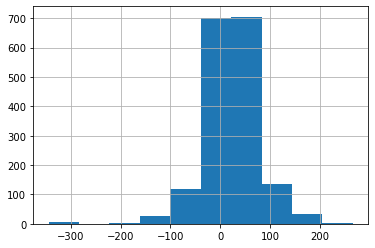

In [17]:
data[data['Currency']=='USD']['Price Premium'].hist()

<AxesSubplot:>

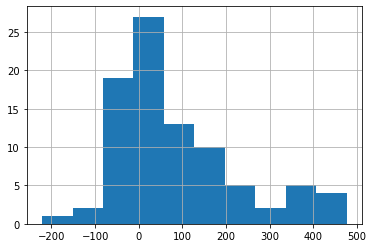

In [18]:
data[data['Currency']!='USD']['Price Premium'].hist()

<b>Remove outliers.</b>

In [19]:
data = data[
            (
                (data['Price Premium']>=(data['Price Premium'].mean() - (3*data['Price Premium'].std())))
                & (data['Price Premium']<=(data['Price Premium'].mean() + (3*data['Price Premium'].std())))
            )
            ]
data.shape

(1793, 33)

# Feature Assessment

Input:
- path to the file
- features : list
- target feature

In [20]:
features = ['Customer Type', 'Customer Industry', 'Grade', 
       'Country', 'Destination Port', 'City State',
       'Shipping Condition', 'Export/Domestic', 'QUANTITY']

In [21]:
for col,type_ in zip(data[features].columns,data[features].dtypes):
    
    if str(type_)=='object' and col!=target:        
        categorical_features.append(col)        
    else:
        numerical_features.append(col)


In [22]:
# handle empty values
for categorical_feature in categorical_features:

    data[categorical_feature].fillna('No data', inplace=True)

for numerical_feature in numerical_features:

    data[numerical_feature].fillna(data[numerical_feature].median(), inplace=True)



In [23]:
categorical_features, numerical_features

(['Customer Type',
  'Customer Industry',
  'Grade',
  'Country',
  'Destination Port',
  'City State',
  'Shipping Condition',
  'Export/Domestic'],
 ['QUANTITY'])

## Feature Enginering

<b>Replace all categorical values with values relative to the target variable.</b>

In [24]:
# handle empty values
for categorical_feature in categorical_features:

    data[categorical_feature].fillna('No data', inplace=True)

for numerical_feature in numerical_features:

    data[numerical_feature].fillna(data[numerical_feature].median(), inplace=True)

# feature engineering
for categorical_feature in categorical_features:

    data[categorical_feature] = data.groupby(categorical_feature)[target].transform('max')


## Linear Model

<b>This will be a function. Input are: dataframe, target varible, and features.</b>

In [25]:
data[features].isnull().sum()

Customer Type         0
Customer Industry     0
Grade                 0
Country               0
Destination Port      0
City State            0
Shipping Condition    0
Export/Domestic       0
QUANTITY              0
dtype: int64

In [26]:
# lin_reg = LinearRegression()
# lin_reg.fit(data[all_possible_features].values,data[target].values.reshape(-1, 1))
# print(lin_reg.intercept_,lin_reg.coef_)
# lin_reg = sm.add_constant(np.array(X_train))

lin_reg = sm.OLS(np.array(data[target].values.reshape(-1, 1),dtype=float),np.array(data[features].values,dtype=float)).fit()
print(lin_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.379
Model:                            OLS   Adj. R-squared (uncentered):              0.376
Method:                 Least Squares   F-statistic:                              121.2
Date:                Thu, 29 Jul 2021   Prob (F-statistic):                   8.39e-178
Time:                        09:52:43   Log-Likelihood:                         -9355.6
No. Observations:                1793   AIC:                                  1.873e+04
Df Residuals:                    1784   BIC:                                  1.878e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [27]:
freg = f_regression(
                    np.array(data[features].values,dtype=float)
                    , np.array(data[target].values.reshape(-1, 1),dtype=float)
                    )
p_values = freg[1]
p_values

/home/cst/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([2.64866766e-40, 3.96324649e-06, 4.35238788e-01, 6.25778406e-56,
       5.56616776e-46, 3.00668013e-01, 1.63832072e-25, 3.35404447e-20,
       8.70101332e-23])

In [28]:
feature_pval = dict()

for p_value, feature in zip(p_values,features):
    
    feature_pval[feature] = round(p_value, 3)    

In [29]:
feature_pval

{'Customer Type': 0.0,
 'Customer Industry': 0.0,
 'Grade': 0.435,
 'Country': 0.0,
 'Destination Port': 0.0,
 'City State': 0.301,
 'Shipping Condition': 0.0,
 'Export/Domestic': 0.0,
 'QUANTITY': 0.0}

<b>Above will a return to this specific function.</b>

# Segmentation

<b>There are many to do this but this exercise uses Decision Tree. The initial was to do multiple segmentation: customers segmentation along with transaction segmentation and then pair these segmentations but then the result was not too good as there limited features on customers segmentation that can be used.</b>

<b>This will be a specific function. Input are:
- Dataframe
- Features
- Target feature

Return values, choose one of below: (can be discussed later)
- Dataframe with labeled cluster    
- JSON with customer code and cluster (could return duplicate values if there are more than 1 customer code for different transaction)
</b>


In [30]:
clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42, ccp_alpha=ccp_alpha)
clf.fit(data[features],data[target])

DecisionTreeRegressor(ccp_alpha=0.001, max_depth=3, min_samples_leaf=100,
                      random_state=42)

In [31]:
text_representation = tree.export_text(clf, feature_names=features)
print(text_representation)

|--- Destination Port <= 120.94
|   |--- Customer Type <= 197.07
|   |   |--- Destination Port <= 51.88
|   |   |   |--- value: [-28.96]
|   |   |--- Destination Port >  51.88
|   |   |   |--- value: [2.13]
|   |--- Customer Type >  197.07
|   |   |--- value: [43.43]
|--- Destination Port >  120.94
|   |--- QUANTITY <= 311.50
|   |   |--- City State <= 166.66
|   |   |   |--- value: [31.47]
|   |   |--- City State >  166.66
|   |   |   |--- value: [48.56]
|   |--- QUANTITY >  311.50
|   |   |--- value: [14.93]



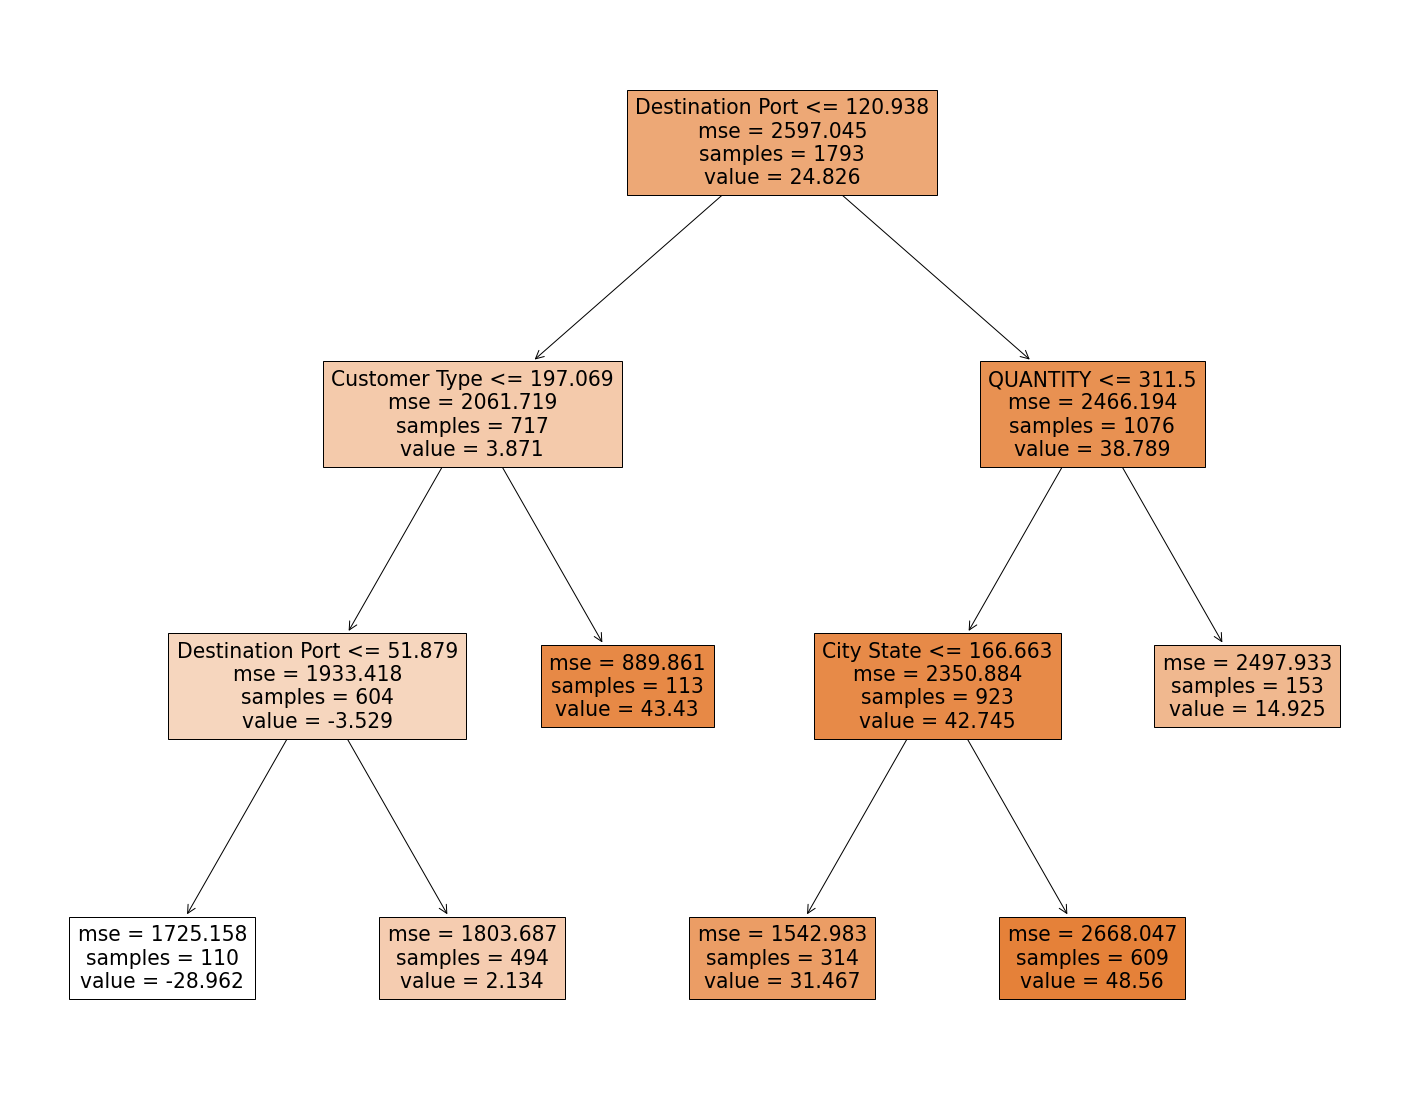

In [32]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, feature_names=features,filled=True)

In [33]:
rules = get_rules(clf, features, None)
rules_dict = {}
for i,r in enumerate(rules):   
    rules_dict[i] = r

pprint.pprint(rules_dict)

{0: 'if (Destination Port > 120.938) and (QUANTITY <= 311.5) and (City State > '
    '166.663) then response: 48.56 | based on 609 samples',
 1: 'if (Destination Port <= 120.938) and (Customer Type <= 197.069) and '
    '(Destination Port > 51.879) then response: 2.134 | based on 494 samples',
 2: 'if (Destination Port > 120.938) and (QUANTITY <= 311.5) and (City State '
    '<= 166.663) then response: 31.467 | based on 314 samples',
 3: 'if (Destination Port > 120.938) and (QUANTITY > 311.5) then response: '
    '14.925 | based on 153 samples',
 4: 'if (Destination Port <= 120.938) and (Customer Type > 197.069) then '
    'response: 43.43 | based on 113 samples',
 5: 'if (Destination Port <= 120.938) and (Customer Type <= 197.069) and '
    '(Destination Port <= 51.879) then response: -28.962 | based on 110 '
    'samples'}


In [34]:
rules_df = tree_to_df(clf, features)
rules_df

,0,1,2,Return
0,Destination Port <= 120.9375,Customer Type <= 197.06922912597656,Destination Port <= 51.87862968444824,return -28.962454545454545
1,Destination Port > 51.87862968444824,None,None,return 2.1337585829959544
2,Customer Type > 197.06922912597656,None,None,return 43.42993725663716
3,Destination Port > 120.9375,QUANTITY <= 311.5,City State <= 166.66326904296875,return 31.467416369426743
4,City State > 166.66326904296875,None,None,return 48.55991738916256
5,QUANTITY > 311.5,None,None,return 14.9253431372549


In [35]:
res = export_py_code(clf, feature_names=features, spacing=4)
print(res)

def decision_tree(Customer_Type, Customer_Industry, Grade, Country, Destination_Port, City_State, Shipping_Condition, Export_Domestic, QUANTITY):
    # DecisionTreeRegressor(ccp_alpha=0.001, max_depth=3, min_samples_leaf=100,
    #                       random_state=42)
    if Destination_Port <= 120.938:
        if Customer_Type <= 197.069:
            if Destination_Port <= 51.8786:
                 return [28.962455]
            if Destination_Port > 51.8786:
                 return [2.133759]
        if Customer_Type > 197.069:
             return [43.429937]
    if Destination_Port > 120.938:
        if QUANTITY <= 311.5:
            if City_State <= 166.663:
                 return [31.467416]
            if City_State > 166.663:
                 return [48.559917]
        if QUANTITY > 311.5:
             return [14.925343]
    



In [36]:
filename = str(uuid.uuid4())
filename = '_'+filename+'.py'
filename

'_9cfec210-4762-44df-a596-d382d0c317b7.py'

In [37]:
# save the string as a function using above filename
with open(filename, 'w') as f:
    f.write(res)    

In [38]:
import sys
import importlib

module_name = os.path.basename(filename).replace('-', '_')
spec = importlib.util.spec_from_loader(
    module_name,
    importlib.machinery.SourceFileLoader(module_name, filename)
)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)
sys.modules[module_name] = module

print(module.decision_tree)
print(module.decision_tree.__name__)
print(get_func_args(module.decision_tree))

<function decision_tree at 0x7f29993cdc10>
decision_tree
['Customer_Type', 'Customer_Industry', 'Grade', 'Country', 'Destination_Port', 'City_State', 'Shipping_Condition', 'Export_Domestic', 'QUANTITY']


In [39]:
module.decision_tree(Customer_Type=212.72594,Customer_Industry=212.72594,Grade=212.72594,Country=212.72594,Destination_Port=212.72594,
               City_State=212.72594, Shipping_Condition=212.72594, Export_Domestic=212.72594, QUANTITY=22.0)

[48.559917]

In [40]:
# f.decision_tree(Customer_Type=212.72594,Customer_Industry=212.72594,Grade=212.72594,Country=212.72594,Destination_Port=212.72594,
#                City_State=212.72594, Shipping_Condition=212.72594, Export_Domestic=212.72594, QUANTITY=22.0)

In [41]:
data

,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Sold to Customer Code,Customer Type,Customer Industry,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE
0,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,8010000770,212.72594,212.72594,138.64267,72000544,ZB30,DAP,212.72594,154.61475,212.72594,212.72594,212.72594,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.000000,1177.000000
1,2017-11-22,QTN-0000013779-1,1,30012429,QUOTATION,CJ POLYMERS SDN. BHD.,8010000714,181.41252,212.72594,204.15681,72000448,TT60SBLC,CFR,116.87500,116.87500,181.41252,181.41252,191.25000,NONCROSSBORDER,M059,2018-01-10,2018-01-03,4.22,306.0,MT,USD,1290.0,1235.58130,1288.75,-53.16870,1290.0,41.669931,1279.999931
2,2017-09-11,QTN-0000012648-1,1,30011297,QUOTATION,SUMIKENG (M) SDN BHD,8010001403,181.41252,212.72594,169.20257,72000539,ZM60,DAP,212.72594,140.69692,154.61475,212.72594,212.72594,NONCROSSBORDER,M167,2017-09-30,2017-09-23,4.29,22.0,MT,USD,1170.0,1230.01552,1135.00,95.01552,1160.0,53.080955,1261.000955
3,2017-05-15,QTN-0000010801-1,2,30009609,QUOTATION,ZHEJIANG FUTURE PETROCHEMICAL,8010001559,181.41252,212.72594,204.15681,72000448,LC60,CFR,13.48438,13.48438,181.41252,181.41252,191.25000,NONCROSSBORDER,M059,2017-05-31,2017-05-24,0.00,102.0,MT,USD,1190.0,1202.83563,1302.50,-99.66437,1310.0,78.407735,1207.002265
4,2018-08-06,QTN-0000018707-1,1,30016459,QUOTATION,CHONG WAH PLASTICS SDN BHD,8010000709,212.72594,212.72594,212.72594,72000608,ZB60,DAP,212.72594,212.72594,212.72594,212.72594,212.72594,NONCROSSBORDER,M167,2018-08-31,2018-08-24,4.04,180.0,MT,USD,1190.0,1312.38099,1181.25,131.13099,1210.0,21.566372,1336.996372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,2020-02-20,QTN-0000029888-1,1,30027440,QUOTATION,PT. BERLINA TBK,8010001242,212.72594,212.72594,204.15681,72000448,LC60,CFR,179.03099,179.03099,181.41252,181.41252,191.25000,NONCROSSBORDER,M169,2020-03-31,2020-03-24,4.06,17.5,MT,USD,910.0,1006.51320,951.00,55.51320,950.0,1.229771,1009.999771
1813,2020-03-26,QTN-0000030542-1,1,30028105,QUOTATION,TYCOPLAS SDN. BHD.,8010001493,212.72594,212.72594,212.72594,72000608,ZM60,DAP,212.72594,212.72594,212.72594,212.72594,212.72594,NONCROSSBORDER,M167,2020-03-31,2020-03-24,4.20,22.5,MT,USD,860.0,850.84511,872.50,-21.65489,880.0,22.278356,874.998356
1814,2020-04-08,QTN-0000030826-1,1,30028345,QUOTATION,"PREMIUM PLAST CO., LTD",8010001205,181.41252,212.72594,204.15681,72000448,TT30,DDP,191.25000,130.00000,191.25000,181.41252,191.25000,NONCROSSBORDER,M169,2020-04-30,2020-04-23,32.48,402.5,MT,USD,746.0,925.20085,945.00,-19.79915,786.0,5.000000,926.000000
1815,2020-04-08,QTN-0000030829-1,1,30028350,QUOTATION,"INTERCORDIA CO., LTD",8010000926,181.41252,212.72594,204.15681,72000448,TT45SBLC,DDP,191.25000,130.00000,191.25000,181.41252,191.25000,NONCROSSBORDER,M169,2020-04-30,2020-04-23,32.48,262.5,MT,USD,746.0,952.93955,945.00,7.93955,786.0,5.000000,955.000000


In [42]:
from import_file import import_file

mylib = import_file(filename)
mylib.decision_tree(Customer_Type=212.72594,Customer_Industry=212.72594,Grade=212.72594,Country=212.72594,Destination_Port=212.72594,
               City_State=212.72594, Shipping_Condition=212.72594, Export_Domestic=212.72594, QUANTITY=22.0)

[48.559917]

In [43]:
get_func_args(module.decision_tree)

['Customer_Type',
 'Customer_Industry',
 'Grade',
 'Country',
 'Destination_Port',
 'City_State',
 'Shipping_Condition',
 'Export_Domestic',
 'QUANTITY']

In [44]:
for a,b in zip(features,get_func_args(module.decision_tree)): 
    print(a,b)
    data.rename(columns={a:b},inplace=True)

Customer Type Customer_Type
Customer Industry Customer_Industry
Grade Grade
Country Country
Destination Port Destination_Port
City State City_State
Shipping Condition Shipping_Condition
Export/Domestic Export_Domestic
QUANTITY QUANTITY


In [45]:
# text_function = 'module.'+str(module.decision_tree.__name__)+'('+','.join([item+"=x['"+item+"']" for item in get_func_args(module.decision_tree)])+')'
# text_function

In [46]:
data['node'] = data[get_func_args(module.decision_tree)].apply(lambda x: module.decision_tree(*x), axis=1)
data['node'] = data['node'].apply(lambda x:str(x).replace('[','').replace(']',''))

le = LabelEncoder()
data['segment'] = le.fit_transform(data['node'])
data['segment'].value_counts(normalize=True)

5    0.339654
1    0.275516
3    0.175125
0    0.085332
4    0.063023
2    0.061350
Name: segment, dtype: float64

In [47]:
data['segment'].value_counts()

5    609
1    494
3    314
0    153
4    113
2    110
Name: segment, dtype: int64

In [48]:
# remove function file

os.remove(filename)

In [50]:
data['index'] = data.index

In [71]:
output_df = data.groupby(['segment'])['index'].apply(list).reset_index() 
output_df

,segment,index
0,0,"[15, 28, 32, 37, 72, 83, 86, 99, 100, 104, 114..."
1,1,"[1, 5, 12, 18, 19, 27, 38, 46, 48, 54, 59, 61,..."
2,2,"[3, 13, 24, 31, 43, 47, 53, 70, 90, 131, 133, ..."
3,3,"[2, 6, 8, 22, 25, 30, 41, 50, 55, 58, 60, 62, ..."
4,4,"[7, 16, 20, 35, 49, 51, 64, 66, 67, 91, 92, 10..."
5,5,"[0, 4, 9, 10, 11, 14, 17, 21, 23, 26, 29, 33, ..."


In [72]:
outputs = []

for i, rows in enumerate(output_df.itertuples(),1):

    _str = '{"segment":'+str(rows[1])+', "index":'+str(rows[2])+'}'
    outputs.append(_str)

final_output = '['+', '.join(outputs)+']'
final_output = final_output.replace("'",'"')					
output_json = json.loads(final_output)


In [87]:
# price_per_segment_df = data[['segment','Price Premium']]

# price_per_segment_df = price_per_segment_df.groupby(['segment'])['Price Premium'].apply(list).reset_index() 

# outputs = []

# for i, rows in enumerate(price_per_segment_df.itertuples(),1):

#     _str = '{"segment":'+str(rows[1])+', "Price Premium":'+str(rows[2])+'}'
#     outputs.append(_str)

# final_output = '['+', '.join(outputs)+']'
# final_output = final_output.replace("'",'"')					
# # output_json = json.loads(final_output)

# # save this json for testing purpose
# with open('price_per_segment.json', 'w') as f:
#     f.write(final_output)



# Price Segmentation

## Without Power Price Index

<b>Input:
- Dataframe
- Target feature
- Cut off in the form of JSON like below
- Signal if the JSON is Power Price Index or not
</b>

In [38]:
cut_off = dict()
cut_off['floor'] = 0.1
cut_off['target'] = 0.5
cut_off['offer'] = 0.9
print(cut_off)

{'floor': 0.1, 'target': 0.5, 'offer': 0.9}


In [39]:
data['segment'].value_counts()

1    550
3    367
5    227
2    195
6    172
4    150
0    132
Name: segment, dtype: int64

Segment: 5
cut_off_values: {'floor': -52.06223540000015, 'target': -21.41139499999997, 'offer': -5.327195199999792}


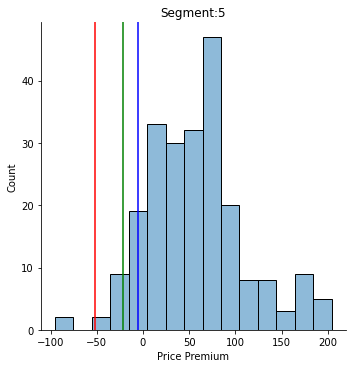

------------------------------------
Segment: 2
cut_off_values: {'floor': -119.81634700000001, 'target': -83.737435, 'offer': -67.96992340000004}


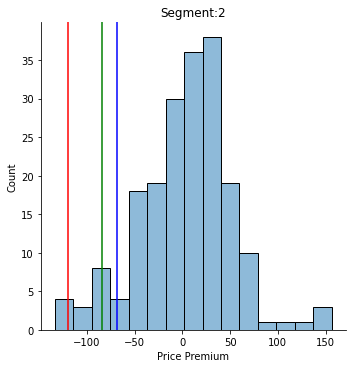

------------------------------------
Segment: 1
cut_off_values: {'floor': -107.43575849999999, 'target': -56.454184999999995, 'offer': -40.32521}


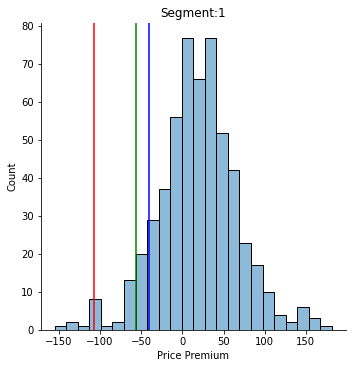

------------------------------------
Segment: 3
cut_off_values: {'floor': -43.6541899999993, 'target': -21.86685599999993, 'offer': -9.395570600000097}


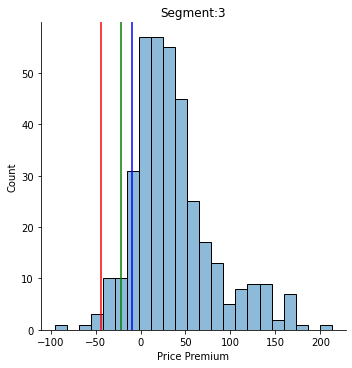

------------------------------------
Segment: 4
cut_off_values: {'floor': -45.653267400000004, 'target': -6.279809499999956, 'offer': -2.0311991999999766}


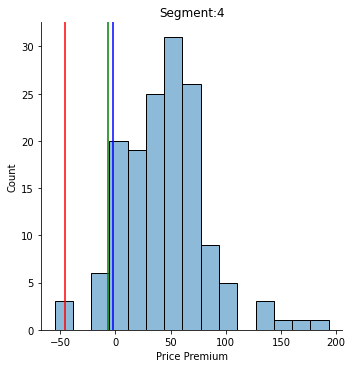

------------------------------------
Segment: 6
cut_off_values: {'floor': -121.5297139, 'target': -82.2618945, 'offer': -66.43258500000007}


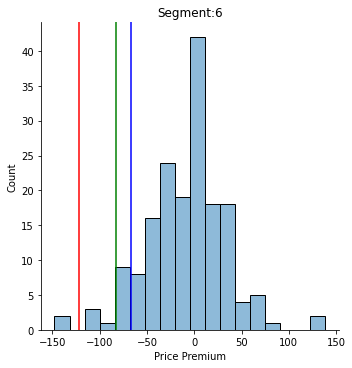

------------------------------------
Segment: 0
cut_off_values: {'floor': -101.6488829, 'target': -76.6984535, 'offer': -54.08154000000002}


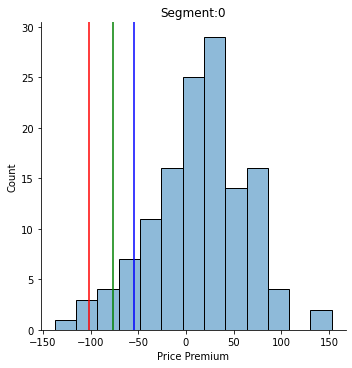

------------------------------------


In [40]:
for segment in data['segment'].unique():

    print('Segment:',segment)
    
    sub = data[data['segment']==segment]
        
    sns.displot(data=sub, x=target,alpha=0.5)
    plt.title('Segment:'+str(segment))        

    cut_off_values = dict()
    
    i = 0
    for k,v in cut_off.items():
    
        cut_off_values[k] = np.percentile(sub[target], v*10)                
        plt.axvline(np.percentile(sub[target], v*10), color=colors[i] )
        
        i=i+1
        
    print('cut_off_values:',cut_off_values)
    

    plt.show()
    
    
    print('------------------------------------')
    


## With Power Price Index

In [41]:
cut_off_price_power = dict()

segment = 0
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.01
cut_off_price_power[segment]['target'] = 0.5
cut_off_price_power[segment]['offer'] = 0.99

segment = 1
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.15
cut_off_price_power[segment]['target'] = 0.65
cut_off_price_power[segment]['offer'] = 0.95

segment = 2
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.05
cut_off_price_power[segment]['target'] = 0.55
cut_off_price_power[segment]['offer'] = 0.95

segment = 3
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.1
cut_off_price_power[segment]['target'] = 0.5
cut_off_price_power[segment]['offer'] = 0.9

segment = 4
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.05
cut_off_price_power[segment]['target'] = 0.75
cut_off_price_power[segment]['offer'] = 0.95

segment = 5
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.15
cut_off_price_power[segment]['target'] = 0.65
cut_off_price_power[segment]['offer'] = 0.85

segment = 6
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.25
cut_off_price_power[segment]['target'] = 0.45
cut_off_price_power[segment]['offer'] = 0.95

segment = 7
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.01
cut_off_price_power[segment]['target'] = 0.5
cut_off_price_power[segment]['offer'] = 0.95

pprint.pprint(cut_off_price_power)

{0: {'floor': 0.01, 'offer': 0.99, 'target': 0.5},
 1: {'floor': 0.15, 'offer': 0.95, 'target': 0.65},
 2: {'floor': 0.05, 'offer': 0.95, 'target': 0.55},
 3: {'floor': 0.1, 'offer': 0.9, 'target': 0.5},
 4: {'floor': 0.05, 'offer': 0.95, 'target': 0.75},
 5: {'floor': 0.15, 'offer': 0.85, 'target': 0.65},
 6: {'floor': 0.25, 'offer': 0.95, 'target': 0.45},
 7: {'floor': 0.01, 'offer': 0.95, 'target': 0.5}}


Segment: 5
(227, 35)
cut_off_values: {'floor': -39.629060700000004, 'target': -10.15931170000005, 'offer': -5.762363000000016}


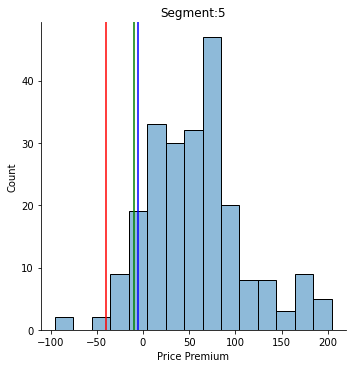

----------------------------------
Segment: 2
(195, 35)
cut_off_values: {'floor': -121.8027236, 'target': -83.66323, 'offer': -61.04152229999984}


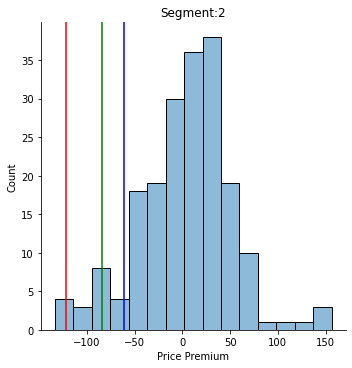

----------------------------------
Segment: 1
(550, 35)
cut_off_values: {'floor': -103.13390370000002, 'target': -51.0, 'offer': -40.08565765000009}


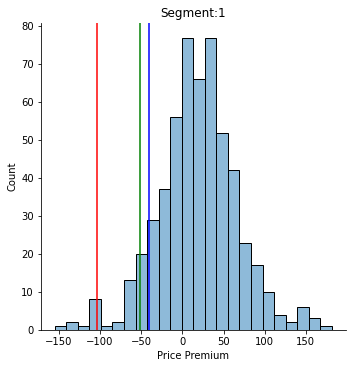

----------------------------------
Segment: 3
(367, 35)
cut_off_values: {'floor': -43.6541899999993, 'target': -21.86685599999993, 'offer': -9.395570600000097}


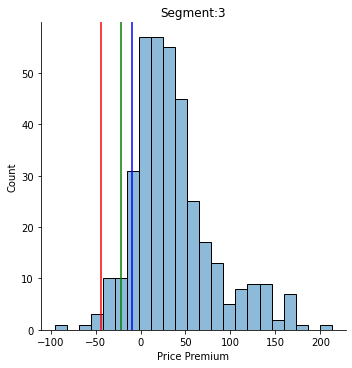

----------------------------------
Segment: 4
(150, 35)
cut_off_values: {'floor': -49.47176474999995, 'target': -3.7327677499999776, 'offer': -1.9247211499999957}


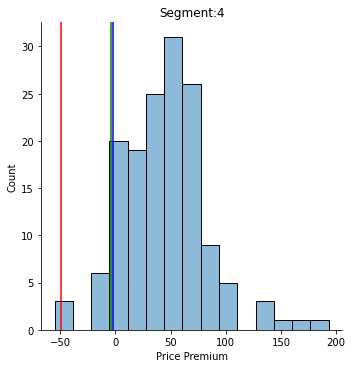

----------------------------------
Segment: 6
(172, 35)
cut_off_values: {'floor': -101.07243025, 'target': -83.8049298, 'offer': -64.50999999999999}


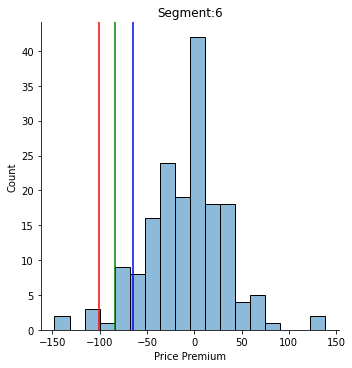

----------------------------------
Segment: 0
(132, 35)
cut_off_values: {'floor': -132.93026219, 'target': -76.6984535, 'offer': -51.09528036}


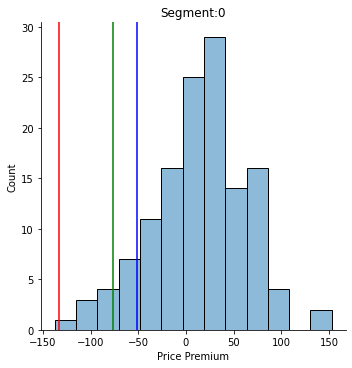

----------------------------------


In [42]:
for segment in data['segment'].unique():
    
    print('Segment:',segment)
    
    sub = data[data['segment']==segment]
      
    print(sub.shape)
    
#     sub[target].hist()
        
    sns.displot(data=sub, x=target, alpha=0.5)
    plt.title('Segment:'+str(segment))        

    cut_off_values = dict()
    
    i = 0
    for k,v in cut_off_price_power[segment].items():
    
        cut_off_values[k] = np.percentile(sub[target], v*10)                
        plt.axvline(np.percentile(sub[target], v*10), color=colors[i] )
        
        i=i+1
        
    print('cut_off_values:',cut_off_values)
    

    plt.show()
    
    print('----------------------------------')

